In [1]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *


In [4]:
from loess import loess_2d

## Create SLA pseudo-Observations 

Get Observations for September 2021 (Equivalent to the tracks during future SWOT campaign)

In [55]:
ds = tools.get_altimetry_data('20210906', 'nrt_along-track_sla_assim', timewindow=5, limits=[-6, 9.2, 35, 44.5])


 Loading SLA observations for 06-Sep-2021. Time window = 5 days

     Jason-3  Number obs = 224
     Sentinel-3B  Number obs = 285
     Altika Drifting Phase  Number obs = 302
     Cryosat-2 New Orbit  Number obs = 362
     Haiyang-2B  Number obs = 188
     Sentinel-3A  Number obs = 309

   Total number of observations = 1670


In [56]:
colors = {'Altika Drifting Phase': 'darkred', 'Cryosat-2 New Orbit': 'green', 'Haiyang-2B': 'orange',
       'Jason-3': 'fuchsia', 'Sentinel-3A': 'gold', 'Sentinel-3B': 'grey'}

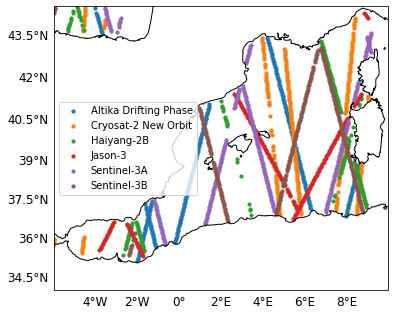

In [57]:
plt.figure(figsize=(6,6))
ax, gl = tools.make_map(limits=[-6,10,34,44.5])
for n in np.unique(ds.sou):
    plt.scatter(ds.longitude.where(ds['sou']==n), ds.latitude.where(ds['sou']==n), 10, transform=gl.crs, label=n)
#plt.scatter(ds.longitude, ds.latitude, 10, c= ds.sou.to_dataframe()['sou'].map(colors), transform=gl.crs)
plt.legend()

### Create SLA Obsfile:

 - For each day get the tracks from September 2021
 - Load eNATL60 SSH fields for corresponding day
 - Interpolate observations from SSH and MDT to corresponding tracks
 - Generate DataFrame as Obsfile

In [119]:
from scipy.interpolate import griddata
from scipy import interpolate

# Load MDT
file_mdt_natl = glob('/LOCALDATA/Data/eNATL60/MDT/*')[1]
ds_mdt = xr.open_dataset(file_mdt_natl) 

# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(ds_mdt.lon.values, ds_mdt.lat.values)
xx = xx.flatten()
yy = yy.flatten()

# Set grid Lon, Lat from MDT as tuple of arrays
lonlat = np.array([xx,yy]).T
nx, ny = ds_mdt.MDT.values.shape

# Interpolator MDT
mdt = ds_mdt.MDT.values
mdt[np.isnan(mdt)] = 10
f_mdt = interpolate.interp2d(ds_mdt.lon.values, ds_mdt.lat.values, mdt, kind='cubic')

# Define dates
date_end = datetime(2021,9,10)
date_ini = date_end - timedelta(days=10)

repobserrSSHaltimeter=0.03*0.03;      # variance 0.0009 m2 <=> std 0.03 m
insobserrSSHaltimeter=0.02*0.02;      # variance 0.0004 m2 <=> std 0.02 m

df_sla_all = pd.DataFrame()

while date_ini <= date_end:
    
    # Define path
    file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date_ini.strftime('%md%d')}.1h_sossheig.nc"

    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_ssh_natl)

    # Set Irregular grid Lon, Lat from SSH as tuple of arrays
    points = np.array([mask_natl.nav_lon.values.flatten(), mask_natl.nav_lat.values.flatten()]).T

    # Set SSH values as array
    values = ds_ssh.sossheig.mean(axis=0).values.flatten()

    # Interpolate SSH to MDT points and reshape into regular grid
    grid_ssh = griddata(points, values, lonlat, method='nearest')
    grid_ssh = np.reshape(grid_ssh, (nx,ny))

    # Interpolator SSH (from regular grid with same dimension)
    ssh = grid_ssh
    ssh[np.isnan(ssh)] = 10
    f_ssh = interpolate.interp2d(ds_mdt.lon.values, ds_mdt.lat.values, ssh, kind='cubic')
    
    # Get real SLA obs for day
    ds_sla = tools.get_altimetry_data(date_ini.strftime('%Y%m%d'), 'nrt_along-track_sla_assim', timewindow=2, limits=[-6, 9.2, 35, 44.5])
    
    # Create Dataframe
    df_sla0 = ds_sla[['longitude', 'latitude', 'sla_filtered', 'sou']].to_dataframe().reset_index(drop=True)
    df_sla = pd.DataFrame(data={'lon': df_sla0.longitude, 'lat': df_sla0.latitude, 
                                'val': df_sla0.sla_filtered, 'source': df_sla0.sou }).reset_index(drop=True)    
    # Extract MDT values at real SLA observation points
    mdt_sla_interp = [f_mdt(df_sla.iloc[i]['lon'], df_sla.iloc[i]['lat']) for i in range(len(df_sla['lat'])) ]
    mdt_sla_interp = np.array(mdt_sla_interp)
    mdt_sla_interp[np.abs(mdt_sla_interp)>1] = np.nan

    # Extract SSH values at real SLA observation points
    ssh_sla_interp = [f_ssh(df_sla.iloc[i]['lon'], df_sla.iloc[i]['lat']) for i in range(len(df_sla['lat']))  ]
    ssh_sla_interp = np.array(ssh_sla_interp)
    ssh_sla_interp[np.abs(ssh_sla_interp)>1] = np.nan

    sla_sla_interp = ssh_sla_interp - mdt_sla_interp
    df_sla['val'] = sla_sla_interp

    # Fill the dates for each observation
    df_sla['year'] = '2009'
    df_sla['month'] = date_ini.month
    df_sla['day'] = date_ini.day
    df_sla['hour'] = date_ini.hour
    df_sla['minute'] = date_ini.minute
    df_sla['source'] = [s.split(' ')[0] for s in df_sla['source'] ]
    
    # Errors
    df_sla['err'] = repobserrSSHaltimeter + insobserrSSHaltimeter
    df_sla['rep'] = 1

    df_sla['var'] = 'h'
    #df_sla['source'] = list(df_sla['sou'].values)
    df_sla['depth'] = 0.0  # Depth

    # Generate random noise to observations
    rand_err_sla = [np.random.normal(0, sigma, 1)[0] for sigma in df_sla['err'] ]

    df_sla['val'] = df_sla['val'] + rand_err_sla

    variables = ['var', 'source', 'year', 'month', 'day', 'hour', 'minute', 'lon', 'lat', 'depth', 'val', 'err', 'rep']

    df_sla = df_sla[variables]

    df_sla_all = df_sla_all.append(df_sla)
    
    date_ini = date_ini + timedelta(days=1)
    
df_sla_all = df_sla_all.dropna().reset_index(drop=True)


 Loading SLA observations for 31-Aug-2021. Time window = 2 days

     Sentinel-3A  Number obs = 42
     Sentinel-3B  Number obs = 37
     Jason-3  Number obs = 67
     Altika Drifting Phase  Number obs = 103
     Haiyang-2B  Number obs = 72
     Cryosat-2 New Orbit  Number obs = 0

   Total number of observations = 321

 Loading SLA observations for 01-Sep-2021. Time window = 2 days

     Sentinel-3A  Number obs = 17
     Cryosat-2 New Orbit  Number obs = 9
     Haiyang-2B  Number obs = 52
     Altika Drifting Phase  Number obs = 54
     Sentinel-3B  Number obs = 160
     Jason-3  Number obs = 87

   Total number of observations = 379

 Loading SLA observations for 02-Sep-2021. Time window = 2 days

     Haiyang-2B  Number obs = 80
     Jason-3  Number obs = 159
     Sentinel-3A  Number obs = 130
     Cryosat-2 New Orbit  Number obs = 136
     Sentinel-3B  Number obs = 105
     Altika Drifting Phase  Number obs = 117

   Total number of observations = 727

 Loading SLA observations fo

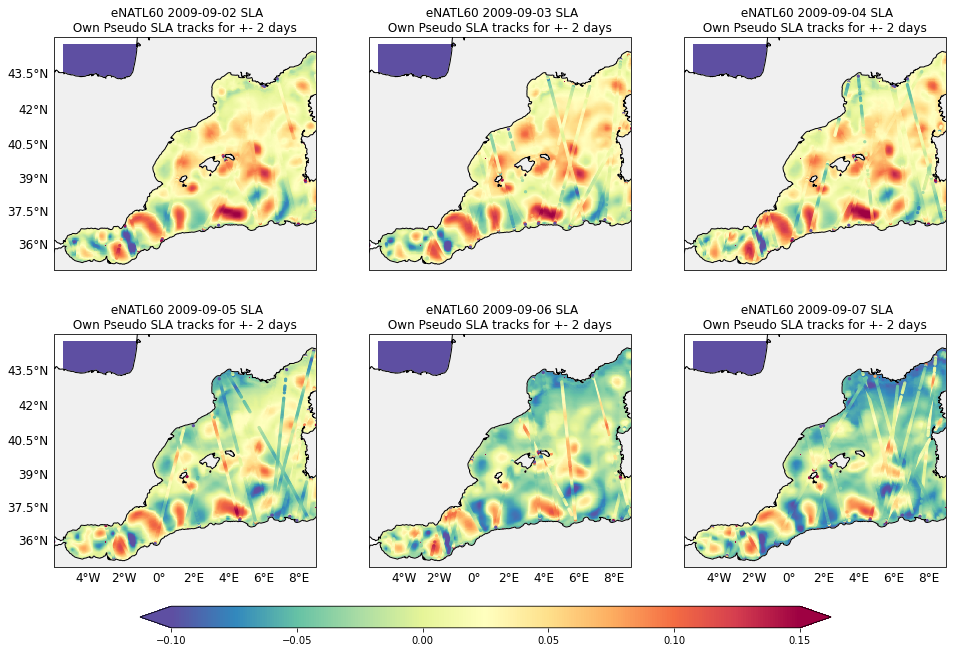

In [264]:
time_window = 2
fig_sla_natl = plt.figure(figsize=(16,10))
for i in range(2,8):

    date = datetime(2009,9,i)

    # Define path
    file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date.strftime('%md%d')}.1h_sossheig.nc"

    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_ssh_natl)

    # Set SSH values as array
    values = ds_ssh.sossheig.mean(axis=0).values.flatten()

    # Interpolate SSH to MDT points and reshape into regular grid
    grid_ssh = griddata(points, values, lonlat, method='nearest')
    grid_ssh = np.reshape(grid_ssh, (nx,ny))

    k = (df_sla_all['day'] == i) | (df_sla_all['day'] == i-time_window) | (df_sla_all['day'] == i+time_window)

    ax, gl = tools.make_map(subplot_dim=(2,3,i-1), continents=True)
    plt.pcolormesh(ds_mdt.lon, ds_mdt.lat, grid_ssh - mdt, vmin=-0.1, vmax=0.15, cmap='Spectral_r', transform=gl.crs)
    a = plt.scatter(df_sla_all.lon[k], df_sla_all.lat[k], 5, df_sla_all.val[k], transform=gl.crs, vmin=-0.1, vmax=0.15, cmap='Spectral_r')
    #plt.colorbar()
    plt.title(F" eNATL60 {date.strftime('%Y-%m-%d')} SLA\n Own Pseudo SLA tracks for +- {time_window} days ")
    
    if i in [3,4,6,7]:
        gl.ylabels_left = False
    if i in [2,3,4]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
#fig_raw_raw10.subplots_adjust(top=0.8)
cbar_ax = fig_sla_natl.add_axes([0.20, 0.05, 0.60, 0.03])
fig_sla_natl.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')

In [265]:
fig_sla_natl.savefig(F"/home/jhernandez/Work/python_notebooks/EuroSea/plots/enatl60_sla_field_and_tracks_6days_{(date-timedelta(days=6)).strftime('%Y%m%d')}_{date.strftime('%Y%m%d')}_time_window-{time_window}-days.png",
           dpi=250, transparent=False, facecolor="w")

### Create Pseudo-obs from WMOP 

In [249]:
# Load MDT
file_mdt_wmop = '/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/10year_mean/roms_WMOP_HINDCAST_surface_avg_10yearmean.nc'
ds_mdt = xr.open_dataset(file_mdt_wmop) 

# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(ds_mdt.lon_rho.values, ds_mdt.lat_rho.values)
xx = xx.flatten()
yy = yy.flatten()

# Set grid Lon, Lat from MDT as tuple of arrays
lonlat = np.array([xx,yy]).T

# Interpolator MDT
mdt = ds_mdt.zeta[0,:,:].values
mdt[np.isnan(mdt)] = 10
f_mdt = interpolate.interp2d(ds_mdt.lon_rho.values, ds_mdt.lat_rho.values, mdt, kind='cubic')

# Define dates
date_end = datetime(2021,9,10)
date_ini = date_end - timedelta(days=10)

repobserrSSHaltimeter=0.03*0.03;      # variance 0.0009 m2 <=> std 0.03 m
insobserrSSHaltimeter=0.02*0.02;      # variance 0.0004 m2 <=> std 0.02 m

df_sla_wmop = pd.DataFrame()

while date_ini <= date_end:
    
    # Define path
    file_wmop = F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/2009/{date_ini.strftime('%m/%d')}/roms_WMOP_HINDCAST_surface_avg_2009{date_ini.strftime('%m%d')}.nc"
    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_wmop)
    
    nlat, nlon = ds_ssh.zeta[0,:,:].shape
    lat_wmop = np.tile(ds_ssh.lat_rho.values,(nlon,1)).T
    lon_wmop = np.tile(ds_ssh.lon_rho.values,(nlat,1))

    from scipy.interpolate import griddata
    from scipy import interpolate

    # Interpolator SSH (from regular grid with same dimension)
    ssh = ds_ssh.zeta[0,:,:].values
    ssh[np.isnan(ssh)] = 10
    f_ssh = interpolate.interp2d(ds_mdt.lon_rho.values, ds_mdt.lat_rho.values, ssh, kind='cubic')
    
    # Get real SLA obs for day
    ds_sla = tools.get_altimetry_data(date_ini.strftime('%Y%m%d'), 'nrt_along-track_sla_assim', timewindow=2, limits=[-6, 9.2, 35, 44.5])
    
    # Create Dataframe
    df_sla0 = ds_sla[['longitude', 'latitude', 'sla_filtered', 'sou']].to_dataframe().reset_index(drop=True)
    df_sla = pd.DataFrame(data={'lon': df_sla0.longitude, 'lat': df_sla0.latitude, 
                                'val': df_sla0.sla_filtered, 'source': df_sla0.sou }).reset_index(drop=True)    
    # Extract MDT values at real SLA observation points
    mdt_sla_interp = [f_mdt(df_sla.iloc[i]['lon'], df_sla.iloc[i]['lat']) for i in range(len(df_sla['lat'])) ]
    mdt_sla_interp = np.array(mdt_sla_interp)
    mdt_sla_interp[np.abs(mdt_sla_interp)>1] = np.nan

    # Extract SSH values at real SLA observation points
    ssh_sla_interp = [f_ssh(df_sla.iloc[i]['lon'], df_sla.iloc[i]['lat']) for i in range(len(df_sla['lat']))  ]
    ssh_sla_interp = np.array(ssh_sla_interp)
    ssh_sla_interp[np.abs(ssh_sla_interp)>1] = np.nan

    sla_sla_interp = ssh_sla_interp - mdt_sla_interp
    df_sla['val'] = sla_sla_interp

    # Fill the dates for each observation
    df_sla['year'] = '2009'
    df_sla['month'] = date_ini.month
    df_sla['day'] = date_ini.day
    df_sla['hour'] = date_ini.hour
    df_sla['minute'] = date_ini.minute
    df_sla['source'] = [s.split(' ')[0] for s in df_sla['source'] ]
    
    # Errors
    df_sla['err'] = repobserrSSHaltimeter + insobserrSSHaltimeter
    df_sla['rep'] = 1

    df_sla['var'] = 'h'
    #df_sla['source'] = list(df_sla['sou'].values)
    df_sla['depth'] = 0.0  # Depth

    # Generate random noise to observations
    rand_err_sla = [np.random.normal(0, sigma, 1)[0] for sigma in df_sla['err'] ]

    df_sla['val'] = df_sla['val'] + rand_err_sla

    variables = ['var', 'source', 'year', 'month', 'day', 'hour', 'minute', 'lon', 'lat', 'depth', 'val', 'err', 'rep']

    df_sla = df_sla[variables]

    df_sla_wmop = df_sla_wmop.append(df_sla)
    
    date_ini = date_ini + timedelta(days=1)
    
df_sla_wmop = df_sla_wmop.dropna().reset_index(drop=True)


 Loading SLA observations for 31-Aug-2021. Time window = 2 days

     Jason-3  Number obs = 67
     Altika Drifting Phase  Number obs = 103
     Sentinel-3B  Number obs = 37
     Sentinel-3A  Number obs = 42
     Haiyang-2B  Number obs = 72
     Cryosat-2 New Orbit  Number obs = 0

   Total number of observations = 321

 Loading SLA observations for 01-Sep-2021. Time window = 2 days

     Sentinel-3B  Number obs = 160
     Altika Drifting Phase  Number obs = 54
     Haiyang-2B  Number obs = 52
     Sentinel-3A  Number obs = 17
     Jason-3  Number obs = 87
     Cryosat-2 New Orbit  Number obs = 9

   Total number of observations = 379

 Loading SLA observations for 02-Sep-2021. Time window = 2 days

     Jason-3  Number obs = 159
     Sentinel-3B  Number obs = 105
     Altika Drifting Phase  Number obs = 117
     Cryosat-2 New Orbit  Number obs = 136
     Haiyang-2B  Number obs = 80
     Sentinel-3A  Number obs = 130

   Total number of observations = 727

 Loading SLA observations fo

#### Plot WMOP mean SSH and pseudo-tracks

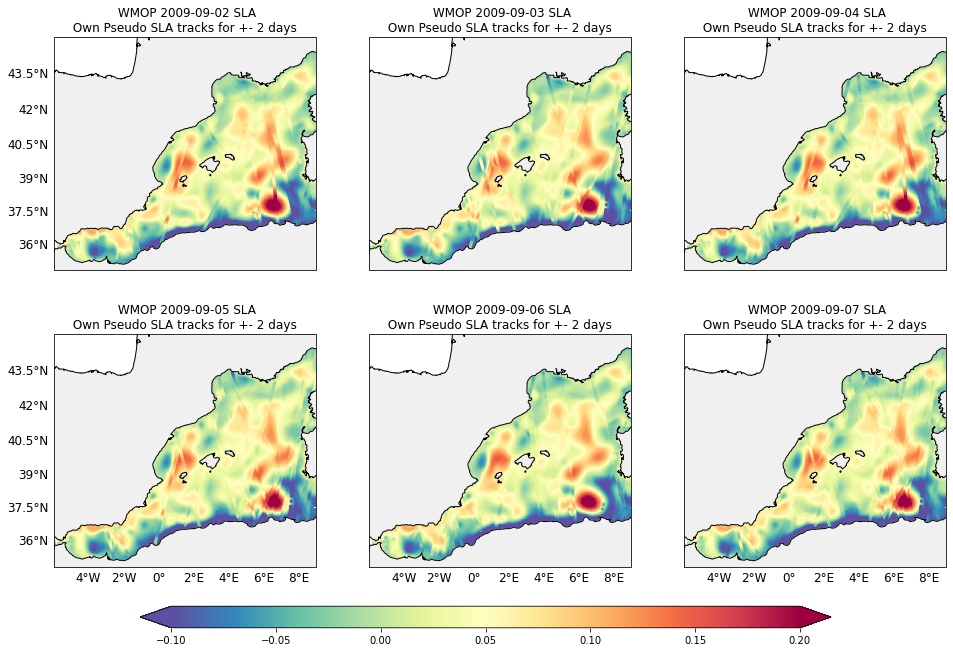

In [253]:
time_window = 2

fig_wmop = plt.figure(figsize=(16,10))

for i in range(2,8):

    date = datetime(2009,9,i)

    # Define path
    file_wmop = F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/2009/{date_ini.strftime('%m/%d')}/roms_WMOP_HINDCAST_surface_avg_2009{date_ini.strftime('%m%d')}.nc"
    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_wmop)

    # Set SSH values as array
    grid_ssh = ds_ssh.zeta[0,:,:].values

    k = (df_sla_wmop['day'] == i) | (df_sla_wmop['day'] == i-time_window) | (df_sla_wmop['day'] == i+time_window)

    ax, gl = tools.make_map(subplot_dim=(2,3,i-1), continents=True)
    plt.pcolormesh(ds_mdt.lon_rho, ds_mdt.lat_rho, grid_ssh - mdt, vmin=-0.1, vmax=0.2, cmap='Spectral_r', transform=gl.crs)
    a = plt.scatter(df_sla_wmop.lon[k], df_sla_wmop.lat[k], 5, df_sla_wmop.val[k], transform=gl.crs, vmin=-0.1, vmax=0.2, cmap='Spectral_r')
   # plt.colorbar()
    plt.title(F" WMOP {date.strftime('%Y-%m-%d')} SLA\n Own Pseudo SLA tracks for +- {time_window} days ")
    
    
#     gl.xlocator = mticker.FixedLocator([0.6, 0.9, 1.2, 1.5, 1.8])
#     gl.ylocator = mticker.FixedLocator([38.30, 38.5, 38.7,38.9, 39.1, 39.3])
#     gl.ylocator = mticker.FixedLocator([38.4, 38.6, 38.8, 39.0, 39.2])
    
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    #gl.xlabel_style = {'size': 24}
    #gl.ylabel_style = {'size': 24}

    
    if i in [3,4,6,7]:
        gl.ylabels_left = False
    if i in [2,3,4]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
    #fig_raw_raw10.subplots_adjust(top=0.8)
cbar_ax = fig_wmop.add_axes([0.20, 0.05, 0.60, 0.03])
fig.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')


In [254]:
fig_wmop.savefig(F"/home/jhernandez/Work/python_notebooks/EuroSea/plots/wmop_sla_field_and_tracks_6days_{(date-timedelta(days=6)).strftime('%Y%m%d')}_{date.strftime('%Y%m%d')}_time_window-{time_window}-days.png",
           dpi=250, transparent=False, facecolor="w")

### Check SSH Time-Serie at certani Grid-Point

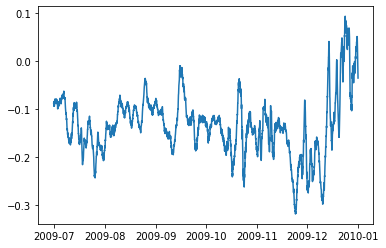

In [3]:
files_ssh = glob('/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m*sossheig.nc')
files_ssh.sort()

ssh = np.array([])
times = np.array([],  dtype='datetime64[ns]')

ny = 500
nx = 600

for file in files_ssh:
    
    ds = xr.open_dataset(file)
    ssh = np.concatenate([ssh, ds.sossheig[:,150,300].values])
    times = np.concatenate([times, ds.sossheig.time_counter.values])
    
    
plt.plot(times, ssh)

#### **Calculate MDT** (w/ High resolution)

In [4]:
ds_tot = xr.open_mfdataset(files_ssh)
mdt0 = ds_tot.sossheig.mean(axis=0)
mdt = mdt0.values

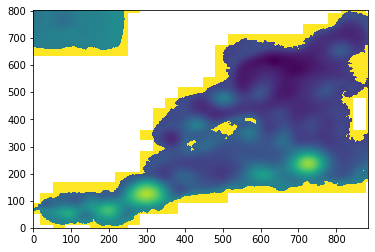

In [7]:
plt.pcolormesh(mdt)

##### **Filters functions**

In [9]:
import scipy.signal as sci_signal
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sci_signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sci_signal.filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sci_signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = sci_signal.filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sci_signal.filtfilt(b, a, data)
    return y


from scipy.fftpack import fft

def get_fft_values(y_values, T):
    N = y_values.shape[0]
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    #f_values = np.arange((N//2))
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values


def plot_fft(f_values, fft_values, title=None, labels=None):
    
    fig = plt.figure(figsize=(16,4))

    ax = plt.subplot(111)
    
    if (isinstance(fft_values, list)):
        for i in range(len(fft_values)):
            plt.plot(f_values[i], fft_values[i], label=labels[i])
    else:
        plt.plot(f_values, fft_values, label=labels[0])
        
    plt.grid()
    ax.set_xlim((0,0.05))
    plt.xlabel('Frequency (1/hours)', fontsize=12)
    
    # Create secondary axis for Period label
    locs, labels = plt.xticks()
    ax2 = plt.twiny()
    ax2.set_xlim((0,0.05))

    lab2 = [np.round(1/l,3) for l in locs]
    plt.xticks(locs[1:], lab2[1:], color='k', fontsize=12)
    plt.xlabel('Period (hours)', color='k', fontsize=12)

    plt.title(title, fontsize=15, fontweight='bold')
    ax.legend()
    plt.show()
    
    return fig

In [10]:
sla = ssh - mdt0[ny,nx]
# Filter DAC effects
sla_filt_inert = butter_bandpass_filter(sla, 1/300, 1/500, 1, order=5)
sla_filt_low = butter_lowpass_filter(sla, 1/500, 1, order=5)
sla_filt_high = butter_highpass_filter(sla, 1/500, 1, order=5)

In [11]:
spatial_mean = ds_tot.sossheig.mean(axis=(1,2)).values

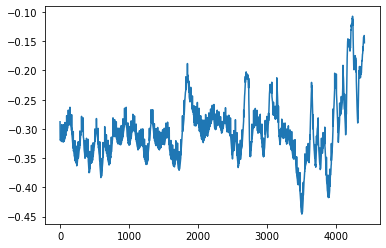

In [12]:
plt.plot(spatial_mean)

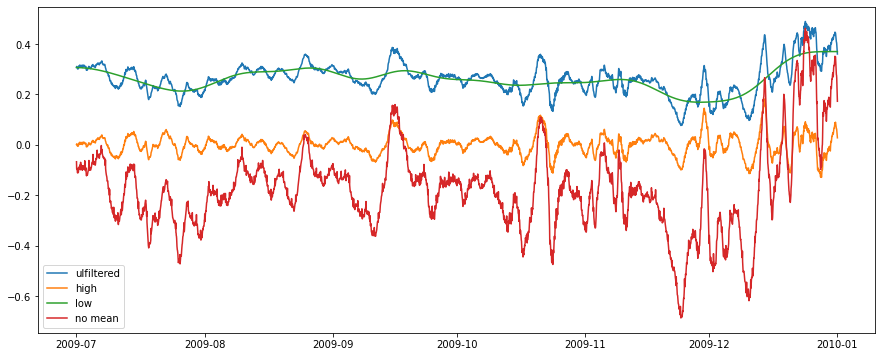

In [14]:
plt.figure(figsize=(15,6))
plt.plot(times, sla, label='ulfiltered')
plt.plot(times, sla_filt_high, label='high')
plt.plot(times, sla_filt_low, label='low')
plt.plot(times, sla + spatial_mean +ssh, label='no mean')
#plt.plot(times, ssh_filt_inert, label='inert')

plt.legend()

#### Fourier Analysis 

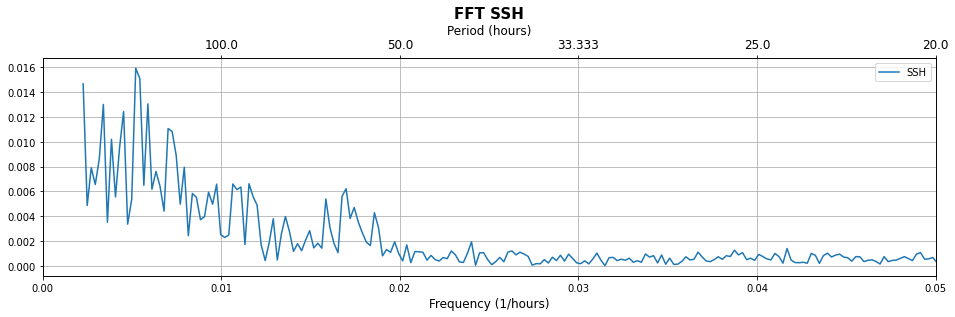

In [58]:
f_ssh, fft_ssh = get_fft_values(ssh,1)

#plot_fft([f_u_hfr, f_u_filt3, f_u_filt2], [fft_u_hfr, fft_u_filt3, fft_u_filt2], title='FFT U-component', labels=['HFR', 'HFR filt', 'HFR filt2'])
fig = plot_fft([f_ssh[10:]], [fft_ssh[10:]], title='FFT SSH', labels=['SSH'])


### Check LOESS filter

In [5]:
# Load mask
mask_natl = xr.open_dataset('/LOCALDATA/Data/eNATL60/mask_eNATL60MEDWEST_3.6.nc')

x = mask_natl.nav_lon.values.flatten()
y = mask_natl.nav_lat.values.flatten()
# Set Irregular grid Lon, Lat from SSH as tuple of arrays
# points = np.array([mask_natl.nav_lon.values.flatten(), mask_natl.nav_lat.values.flatten()]).T

date = datetime(2009,9,1)


# Define path
file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y{date.strftime('%Ym%md%d')}.1h_sossheig.nc"
file_mdt_natl = glob('/LOCALDATA/Data/eNATL60/MDT/*')[1]

# Load SST Dataset
ds_ssh = xr.open_dataset(file_ssh_natl)
ds_mdt = xr.open_dataset(file_mdt_natl)  

In [40]:
from scipy.interpolate import griddata
from scipy import interpolate

# Set Irregular grid Lon, Lat from SSH as tuple of arrays
points = np.array([mask_natl.nav_lon.values.flatten(), mask_natl.nav_lat.values.flatten()]).T

ssh = ds_ssh.sossheig.mean(axis=0).values
mask0 = (mask_natl.fmaskutil[0,:,:]==0).values
ssh[mask0] = np.nan

# Set SSH values as array
values = ssh.flatten()
values_mask = mask_natl.fmaskutil[0,:,:].values.flatten()

# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(ds_mdt.lon.values, ds_mdt.lat.values)
xx = xx.flatten()
yy = yy.flatten()

# Set grid Lon, Lat from MDT as tuple of arrays
lonlat = np.array([xx,yy]).T
nx, ny = ds_mdt.MDT.values.shape

# Interpolate SSH to MDT points and reshape into regular grid
grid_ssh = griddata(points, values, lonlat, method='nearest')
grid_ssh = np.reshape(grid_ssh, (nx,ny))

grid_mask = griddata(points, values_mask, lonlat, method='nearest')
grid_mask = np.reshape(grid_mask, (nx,ny))

In [60]:
# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(ds_mdt.lon.values, ds_mdt.lat.values)


In [ ]:
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve

kernel = Gaussian2DKernel(x_stddev=4)
ssh_conv = convolve(grid_ssh, kernel)


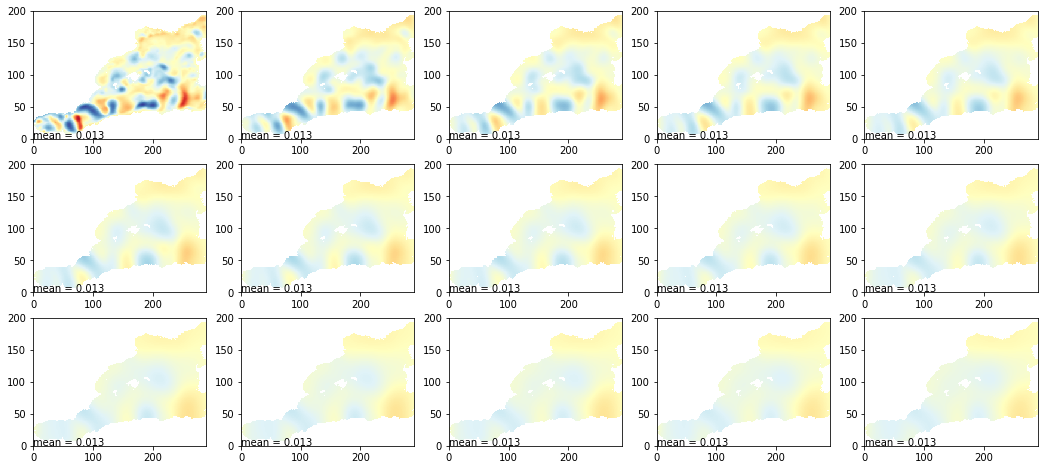

In [213]:
kernel = Gaussian2DKernel(x_stddev=5)

grid_sla = grid_ssh - ds_mdt.MDT.values
sla_conv = grid_sla

plt.figure(figsize=(18,8))
for i in range(15):
    

    plt.subplot(3,5,i+1)  # left side
    plt.pcolormesh(sla_conv, cmap='RdYlBu', vmin=-0.15, vmax=0.15)
    plt.text(0.2,0.8,F'mean = {np.nanmean(sla_conv):0.3f}')
    sla_conv = convolve(sla_conv, kernel)
    sla_conv[grid_mask==0] = np.nan
    #plt.colorbar()

In [150]:
kernel = Gaussian2DKernel(x_stddev=25)

grid_sla = grid_ssh - ds_mdt.MDT.values
sla_conv = convolve(grid_sla, kernel)
sla_conv[grid_mask==0] = np.nan

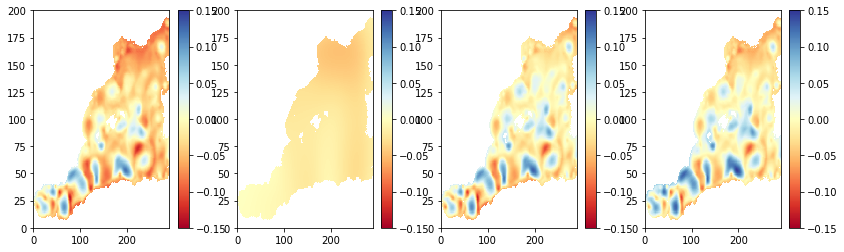

In [155]:
fig = plt.figure(figsize=(14,4))
#plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(141)  # left side
plt.pcolormesh(grid_sla, cmap='RdYlBu', vmin=-0.15, vmax=0.15)
plt.colorbar()

ax2 = fig.add_subplot(142)  # right side
plt.pcolormesh(sla_conv, cmap='RdYlBu', vmin=-0.15, vmax=0.15)
plt.colorbar()

ax3 = fig.add_subplot(143) 
plt.pcolormesh(grid_sla-sla_conv, cmap='RdYlBu', vmin=-0.15, vmax=0.15)
plt.colorbar()

ax4 = fig.add_subplot(144) 
plt.pcolormesh(grid_sla - np.nanmean(grid_sla), cmap='RdYlBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.show()


In [154]:
print(np.nanmean(grid_sla))
print(np.nanmean())

-0.0269983

### Generate eNATL60 pseudo-obs (Take out mean SLA field to filter)

In [133]:
from scipy.interpolate import griddata
from scipy import interpolate

# Load MDT
file_mdt_natl = glob('/LOCALDATA/Data/eNATL60/MDT/*')[1]
ds_mdt = xr.open_dataset(file_mdt_natl) 

# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(ds_mdt.lon.values, ds_mdt.lat.values)
xx = xx.flatten()
yy = yy.flatten()

# Set grid Lon, Lat from MDT as tuple of arrays
lonlat = np.array([xx,yy]).T
nx, ny = ds_mdt.MDT.values.shape

# Interpolator MDT
mdt = ds_mdt.MDT.values
mdt[np.isnan(mdt)] = 10
f_mdt = interpolate.interp2d(ds_mdt.lon.values, ds_mdt.lat.values, mdt, kind='cubic')

# Define dates
date_end = datetime(2021,9,10)
date_ini = date_end - timedelta(days=10)

repobserrSSHaltimeter=0.03*0.03;      # variance 0.0009 m2 <=> std 0.03 m
insobserrSSHaltimeter=0.02*0.02;      # variance 0.0004 m2 <=> std 0.02 m

df_sla_all = pd.DataFrame()

while date_ini <= date_end:
    
    # Define path
    file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date_ini.strftime('%md%d')}.1h_sossheig.nc"

    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_ssh_natl)

    # Set Irregular grid Lon, Lat from SSH as tuple of arrays
    points = np.array([mask_natl.nav_lon.values.flatten(), mask_natl.nav_lat.values.flatten()]).T

    # Set SSH values as array
    values = ds_ssh.sossheig.mean(axis=0).values.flatten()

    # Interpolate SSH to MDT points and reshape into regular grid
    grid_ssh = griddata(points, values, lonlat, method='nearest')
    grid_ssh = np.reshape(grid_ssh, (nx,ny))
    
    # Mask SSH
    grid_ssh[grid_mask==0] = np.nan
    # Get SLA (SSH-MDT) and take out spatial mean
    grid_sla = grid_ssh - mdt
    grid_sla = grid_sla - np.nanmean(grid_sla)

    # Interpolator SLA (from regular grid with same dimension)
    sla = grid_sla
    sla[np.isnan(sla)] = 10
    f_sla = interpolate.interp2d(ds_mdt.lon.values, ds_mdt.lat.values, sla, kind='cubic')
    
    # Get real SLA obs for day
    ds_sla = tools.get_altimetry_data(date_ini.strftime('%Y%m%d'), 'nrt_along-track_sla_assim', timewindow=2, limits=[-6, 9.2, 35, 44.5])
    
    # Create Dataframe
    df_sla0 = ds_sla[['longitude', 'latitude', 'sla_filtered', 'sou']].to_dataframe().reset_index(drop=True)
    df_sla = pd.DataFrame(data={'lon': df_sla0.longitude, 'lat': df_sla0.latitude, 
                                'val': df_sla0.sla_filtered, 'source': df_sla0.sou }).reset_index(drop=True)    
   
    # Extract SSH values at real SLA observation points
    sla_interp = [f_sla(df_sla.iloc[i]['lon'], df_sla.iloc[i]['lat']) for i in range(len(df_sla['lat']))  ]
    sla_interp = np.array(sla_interp)
    sla_interp[np.abs(sla_interp)>1] = np.nan

    df_sla['val'] = sla_interp

    # Fill the dates for each observation
    df_sla['year'] = '2009'
    df_sla['month'] = date_ini.month
    df_sla['day'] = date_ini.day
    df_sla['hour'] = date_ini.hour
    df_sla['minute'] = date_ini.minute
    df_sla['source'] = [s.split(' ')[0] for s in df_sla['source'] ]
    
    # Errors
    df_sla['err'] = repobserrSSHaltimeter + insobserrSSHaltimeter
    df_sla['rep'] = 1

    df_sla['var'] = 'h'
    #df_sla['source'] = list(df_sla['sou'].values)
    df_sla['depth'] = 0.0  # Depth

    # Generate random noise to observations
    rand_err_sla = [np.random.normal(0, sigma, 1)[0] for sigma in df_sla['err'] ]

    df_sla['val'] = df_sla['val'] + rand_err_sla

    variables = ['var', 'source', 'year', 'month', 'day', 'hour', 'minute', 'lon', 'lat', 'depth', 'val', 'err', 'rep']

    df_sla = df_sla[variables]

    df_sla_all = df_sla_all.append(df_sla)
    
    date_ini = date_ini + timedelta(days=1)
    
df_sla_all = df_sla_all.dropna().reset_index(drop=True)


 Loading SLA observations for 31-Aug-2021. Time window = 2 days

     Sentinel-3A  Number obs = 42
     Sentinel-3B  Number obs = 37
     Jason-3  Number obs = 67
     Altika Drifting Phase  Number obs = 103
     Haiyang-2B  Number obs = 72
     Cryosat-2 New Orbit  Number obs = 0

   Total number of observations = 321

 Loading SLA observations for 01-Sep-2021. Time window = 2 days

     Sentinel-3A  Number obs = 17
     Cryosat-2 New Orbit  Number obs = 9
     Haiyang-2B  Number obs = 52
     Altika Drifting Phase  Number obs = 54
     Sentinel-3B  Number obs = 160
     Jason-3  Number obs = 87

   Total number of observations = 379

 Loading SLA observations for 02-Sep-2021. Time window = 2 days

     Haiyang-2B  Number obs = 80
     Jason-3  Number obs = 159
     Sentinel-3A  Number obs = 130
     Cryosat-2 New Orbit  Number obs = 136
     Sentinel-3B  Number obs = 105
     Altika Drifting Phase  Number obs = 117

   Total number of observations = 727

 Loading SLA observations fo

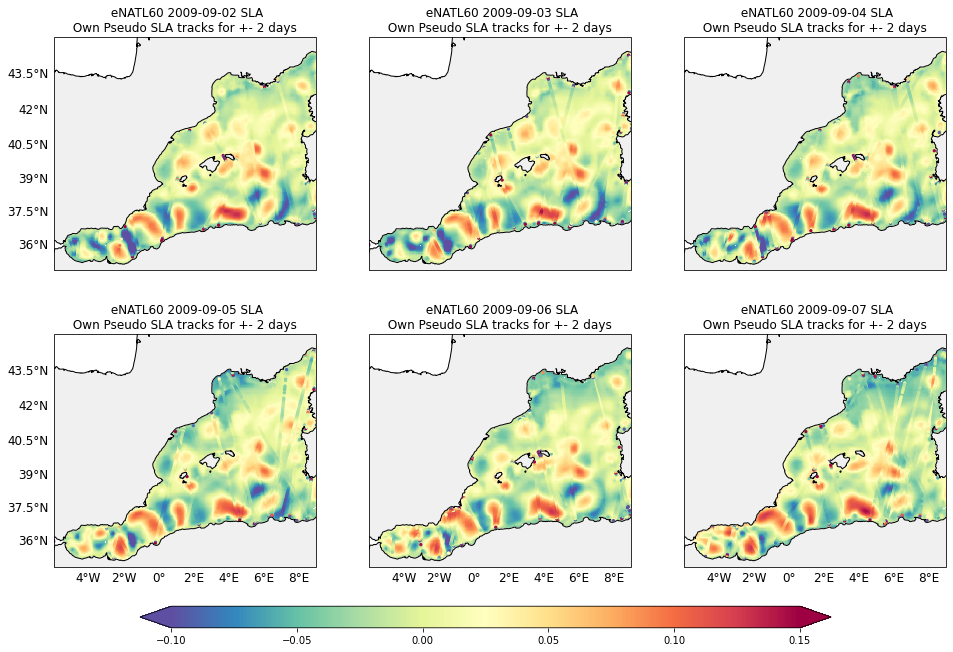

In [134]:
time_window = 2
fig_sla_natl = plt.figure(figsize=(16,10))
for i in range(2,8):

    date = datetime(2009,9,i)

    # Define path
    file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date.strftime('%md%d')}.1h_sossheig.nc"

    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_ssh_natl)

    # Set SSH values as array
    values = ds_ssh.sossheig.mean(axis=0).values.flatten()

    # Interpolate SSH to MDT points and reshape into regular grid
    grid_ssh = griddata(points, values, lonlat, method='nearest')
    grid_ssh = np.reshape(grid_ssh, (nx,ny))
    # Mask SSH
    grid_ssh[grid_mask==0] = np.nan
    
    grid_sla = grid_ssh - ds_mdt.MDT.values
    grid_sla = grid_sla - np.nanmean(grid_sla)

    k = (df_sla_all['day'] == i) | (df_sla_all['day'] == i-time_window) | (df_sla_all['day'] == i+time_window)

    ax, gl = tools.make_map(subplot_dim=(2,3,i-1), continents=True)
    plt.pcolormesh(ds_mdt.lon, ds_mdt.lat, grid_sla, vmin=-0.1, vmax=0.15, cmap='Spectral_r', transform=gl.crs)
    a = plt.scatter(df_sla_all.lon[k], df_sla_all.lat[k], 5, df_sla_all.val[k], transform=gl.crs, vmin=-0.1, vmax=0.15, cmap='Spectral_r')
    #plt.colorbar()
    plt.title(F" eNATL60 {date.strftime('%Y-%m-%d')} SLA\n Own Pseudo SLA tracks for +- {time_window} days ")
    
    if i in [3,4,6,7]:
        gl.ylabels_left = False
    if i in [2,3,4]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
#fig_raw_raw10.subplots_adjust(top=0.8)
cbar_ax = fig_sla_natl.add_axes([0.20, 0.05, 0.60, 0.03])
fig_sla_natl.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')

### Apply Gaussian Filter

In [263]:
from scipy.interpolate import griddata
from scipy import interpolate

# Load MDT
file_mdt_natl = glob('/LOCALDATA/Data/eNATL60/MDT/*')[1]
ds_mdt = xr.open_dataset(file_mdt_natl) 

# Meshgrid Lon, Lat from MDT
xx, yy = np.meshgrid(ds_mdt.lon.values, ds_mdt.lat.values)
xx = xx.flatten()
yy = yy.flatten()

# Set grid Lon, Lat from MDT as tuple of arrays
lonlat = np.array([xx,yy]).T
nx, ny = ds_mdt.MDT.values.shape

# Interpolator MDT
mdt = ds_mdt.MDT.values
mdt[np.isnan(mdt)] = 10
f_mdt = interpolate.interp2d(ds_mdt.lon.values, ds_mdt.lat.values, mdt, kind='cubic')

# Kernel for filtering
kernel = Gaussian2DKernel(x_stddev=25)

# Define dates
date_end = datetime(2021,9,10)
date_ini = date_end - timedelta(days=10)

repobserrSSHaltimeter=0.03*0.03;      # variance 0.0009 m2 <=> std 0.03 m
insobserrSSHaltimeter=0.02*0.02;      # variance 0.0004 m2 <=> std 0.02 m

df_sla_all2 = pd.DataFrame()

while date_ini <= date_end:
    
    # Define path
    file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date_ini.strftime('%md%d')}.1h_sossheig.nc"

    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_ssh_natl)

    # Set Irregular grid Lon, Lat from SSH as tuple of arrays
    points = np.array([mask_natl.nav_lon.values.flatten(), mask_natl.nav_lat.values.flatten()]).T

    # Set SSH values as array
    values = ds_ssh.sossheig.mean(axis=0).values.flatten()

    # Interpolate SSH to MDT points and reshape into regular grid
    grid_ssh = griddata(points, values, lonlat, method='nearest')
    grid_ssh = np.reshape(grid_ssh, (nx,ny))
    
    # Mask SSH
    grid_ssh[grid_mask==0] = np.nan
    # Get SLA (SSH-MDT) and take out spatial mean
    grid_sla = grid_ssh - mdt
    
    # Filter SLA field using Gaussian filter
    sla_conv = convolve(grid_sla, kernel)
    sla_conv[grid_mask==0] = np.nan
    
    # Extract Large scale to SLA (SLA filtered)
    grid_sla = grid_sla - sla_conv


    # Interpolator SLA (from regular grid with same dimension)
    sla = grid_sla
    sla[np.isnan(sla)] = 10
    f_sla = interpolate.interp2d(ds_mdt.lon.values, ds_mdt.lat.values, sla, kind='cubic')
    
    # Get real SLA obs for day
    ds_sla = tools.get_altimetry_data(date_ini.strftime('%Y%m%d'), 'nrt_along-track_sla_assim', timewindow=2, limits=[-6, 9.2, 35, 44.5])
    
    # Create Dataframe
    df_sla0 = ds_sla[['longitude', 'latitude', 'sla_filtered', 'sou']].to_dataframe().reset_index(drop=True)
    df_sla = pd.DataFrame(data={'lon': df_sla0.longitude, 'lat': df_sla0.latitude, 
                                'val': df_sla0.sla_filtered, 'source': df_sla0.sou }).reset_index(drop=True)    
   
    # Extract SSH values at real SLA observation points
    sla_interp = [f_sla(df_sla.iloc[i]['lon'], df_sla.iloc[i]['lat']) for i in range(len(df_sla['lat']))  ]
    sla_interp = np.array(sla_interp)
    #delta = 4*np.nanstd(grid_sla.flatten())
    sla_interp[np.abs(sla_interp)> 0.12] = np.nan

    df_sla['val'] = sla_interp

    # Fill the dates for each observation
    df_sla['year'] = '2009'
    df_sla['month'] = date_ini.month
    df_sla['day'] = date_ini.day
    df_sla['hour'] = date_ini.hour
    df_sla['minute'] = date_ini.minute
    df_sla['source'] = [s.split(' ')[0] for s in df_sla['source'] ]
    
    # Errors
    df_sla['err'] = repobserrSSHaltimeter + insobserrSSHaltimeter
    df_sla['rep'] = 1

    df_sla['var'] = 'h'
    #df_sla['source'] = list(df_sla['sou'].values)
    df_sla['depth'] = 0.0  # Depth

    # Generate random noise to observations
    rand_err_sla = [np.random.normal(0, sigma, 1)[0] for sigma in df_sla['err'] ]

    #df_sla['val'] = df_sla['val'] + rand_err_sla

    variables = ['var', 'source', 'year', 'month', 'day', 'hour', 'minute', 'lon', 'lat', 'depth', 'val', 'err', 'rep']

    df_sla = df_sla[variables]

    df_sla_all2 = df_sla_all2.append(df_sla)
    
    date_ini = date_ini + timedelta(days=1)
    
df_sla_all2 = df_sla_all2.dropna().reset_index(drop=True)


 Loading SLA observations for 31-Aug-2021. Time window = 2 days

     Sentinel-3A  Number obs = 42
     Sentinel-3B  Number obs = 37
     Jason-3  Number obs = 67
     Altika Drifting Phase  Number obs = 103
     Haiyang-2B  Number obs = 72
     Cryosat-2 New Orbit  Number obs = 0

   Total number of observations = 321

 Loading SLA observations for 01-Sep-2021. Time window = 2 days

     Sentinel-3A  Number obs = 17
     Cryosat-2 New Orbit  Number obs = 9
     Haiyang-2B  Number obs = 52
     Altika Drifting Phase  Number obs = 54
     Sentinel-3B  Number obs = 160
     Jason-3  Number obs = 87

   Total number of observations = 379

 Loading SLA observations for 02-Sep-2021. Time window = 2 days

     Haiyang-2B  Number obs = 80
     Jason-3  Number obs = 159
     Sentinel-3A  Number obs = 130
     Cryosat-2 New Orbit  Number obs = 136
     Sentinel-3B  Number obs = 105
     Altika Drifting Phase  Number obs = 117

   Total number of observations = 727

 Loading SLA observations fo

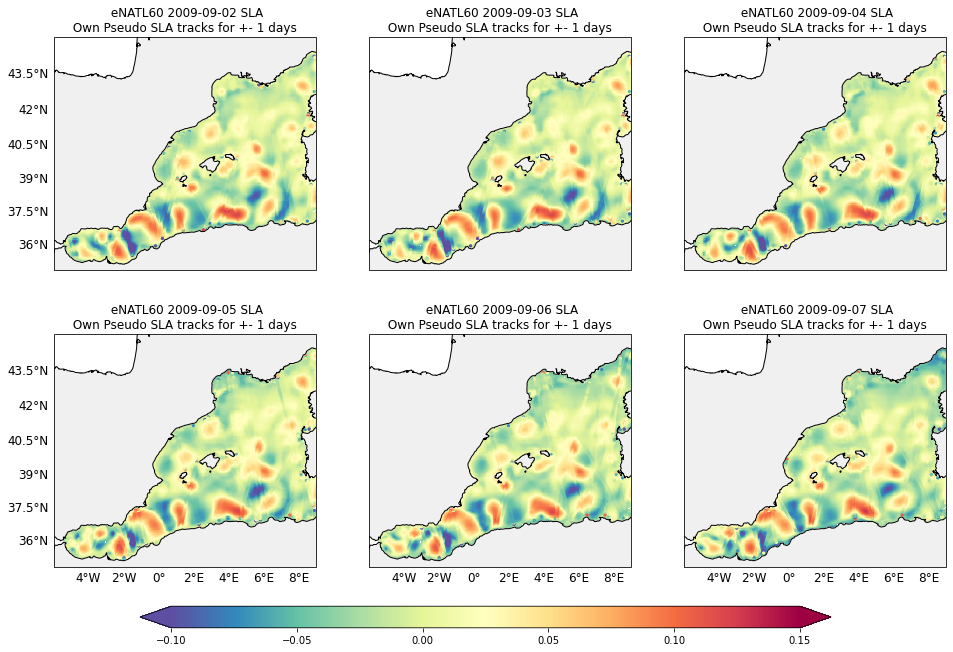

In [190]:
time_window = 1
fig_sla_natl = plt.figure(figsize=(16,10))
for i in range(2,8):

    date = datetime(2009,9,i)

    # Define path
    file_ssh_natl = F"/LOCALDATA/Data/eNATL60/SSH/eNATL60MEDWEST-BLB002_y2009m{date.strftime('%md%d')}.1h_sossheig.nc"

    # Load SST Dataset
    ds_ssh = xr.open_dataset(file_ssh_natl)

    # Set SSH values as array
    values = ds_ssh.sossheig.mean(axis=0).values.flatten()

    # Interpolate SSH to MDT points and reshape into regular grid
    grid_ssh = griddata(points, values, lonlat, method='nearest')
    grid_ssh = np.reshape(grid_ssh, (nx,ny))
    # Mask SSH
    grid_ssh[grid_mask==0] = np.nan
    
    # Get SLA (SSH-MDT) and take out spatial mean
    grid_sla = grid_ssh - mdt
    
    # Filter SLA field using Gaussian filter
    sla_conv = convolve(grid_sla, kernel)
    sla_conv[grid_mask==0] = np.nan
    
    # Extract Large scale to SLA (SLA filtered)
    grid_sla = grid_sla - sla_conv
    
    k = (df_sla_all2['day'] == i) | (df_sla_all2['day'] == i-time_window) | (df_sla_all2['day'] == i+time_window)

    ax, gl = tools.make_map(subplot_dim=(2,3,i-1), continents=True)
    plt.pcolormesh(ds_mdt.lon, ds_mdt.lat, grid_sla, vmin=-0.1, vmax=0.15, cmap='Spectral_r', transform=gl.crs)
    a = plt.scatter(df_sla_all2.lon[k], df_sla_all2.lat[k], 5, df_sla_all2.val[k], transform=gl.crs, vmin=-0.1, vmax=0.15, cmap='Spectral_r')
    #plt.colorbar()
    plt.title(F" eNATL60 {date.strftime('%Y-%m-%d')} SLA\n Own Pseudo SLA tracks for +- {time_window} days ")
    
    if i in [3,4,6,7]:
        gl.ylabels_left = False
    if i in [2,3,4]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
#fig_raw_raw10.subplots_adjust(top=0.8)
cbar_ax = fig_sla_natl.add_axes([0.20, 0.05, 0.60, 0.03])
fig_sla_natl.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')

In [191]:
fig_sla_natl.savefig(F"/home/jhernandez/Work/python_notebooks/EuroSea/plots/enatl60_gaussian_filtered_sla_field_and_tracks_6days_{(date-timedelta(days=6)).strftime('%Y%m%d')}_{date.strftime('%Y%m%d')}_time_window-{time_window}-days.png",
           dpi=250, transparent=False, facecolor="w")

0.14313453435897827


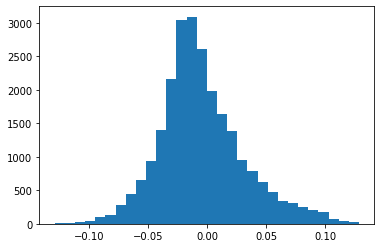

In [186]:
print(4*np.nanstd(grid_sla.flatten()))

plt.hist(grid_sla.flatten(), bins=30)
plt.show()

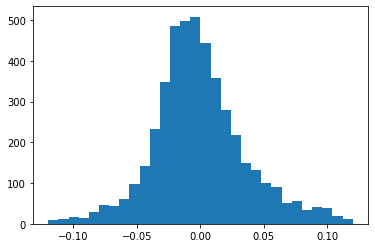

In [187]:
plt.hist(df_sla_all2['val'], bins=30)
plt.show()

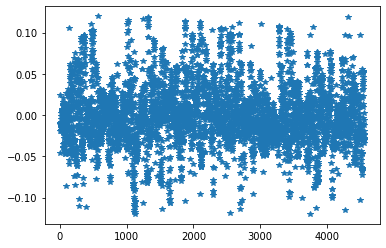

In [188]:
plt.plot(df_sla_all2['val'],'*')